In [14]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
# will be used to load MATLAB mat datafile format
from scipy.io import loadmat
import utils
import scipy.io # used to load matlab-formatted .m files.

### 1. load dataset

In [3]:
data_dict = loadmat(os.path.join('ex4data1.mat'))

X = data_dict['X']
y = data_dict['y'].ravel()

M = X.shape[0] # = 400 pixels per sample
N = X.shape[1] # = 5000 samples
L = 26 # = number of nodes in the hidden layer (including bias node)
K = len(np.unique(y)) # = 10 distinct classes for this example.

### 2. visualize data

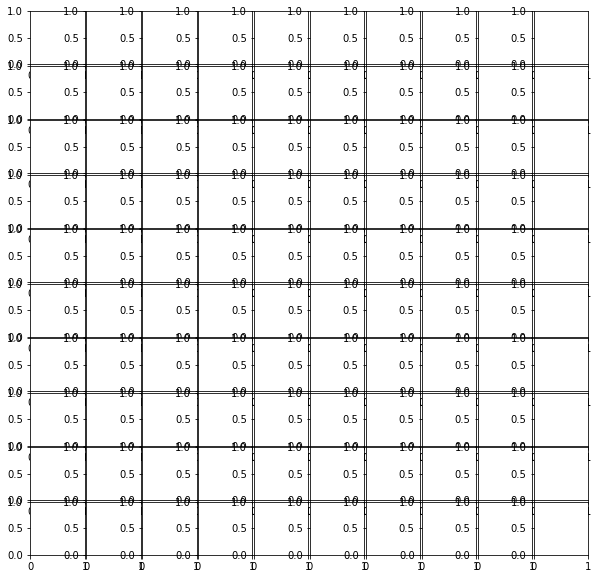

In [5]:
# This gives us a 5000 by 400 matrix X 
# where every row is a training example for a handwritten digit image.
# Randomly select 100 data points to display
rand_indices = np.random.choice(M, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

In [8]:
# Add a column of ones to the data matrix that allows us to treat the intercept parameter as a feature.
X = np.hstack((np.ones((M, 1)), X))

### 3. load already trained weights

In [6]:
# It has 3 layers - an input layer, a hidden layer and an output layer. 
# Since the images are of size $20 * 20$, this gives us 400 input layer units
# (not counting the extra bias unit which always outputs +1). 
# The training data was loaded into the variables X and y above.

In [7]:
# You have been provided with a set of network parameters already trained.
# These are stored in ex4weights.mat and will be loaded in the next cell of this notebook into Theta1 and Theta2. 
# The parameters have dimensions that are sized for a neural network with 25 units in the second layer
# and 10 output units (corresponding to the 10 digit classes).
# images are of size $20 \times 20$, this gives us 400 input layer units
# 5000-dimensional vector y that contains labels for the training set.

In [6]:

# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits - 
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

In [15]:
# Load the weights into variables Theta1 and Theta2
weights = scipy.io.loadmat('ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
Theta1.shape


(25, 401)

In [16]:
Theta2.shape

(10, 26)

In [17]:
# Unroll parameters 
nn_params_saved = np.concatenate((Theta1.flatten(), Theta2.flatten()))
nn_params_saved.shape

(10285,)

# 4. Feedforward and cost function

<a id="section1"></a>
### 4.1 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>

In [9]:
def sigmoid(x):
    h = 1 / (1 + np.exp(-x))
    return h

In [18]:
# Generate a one-hot encoding, Y, of the target vector, y.
Y = np.zeros((M, K), dtype='uint8') 

for i, row in enumerate(Y):
    Y[i, y[i] - 1] = 1

In [21]:
Y.shape

(5000, 10)

In [53]:

def nn_cost_function(nn_params, X, Y, M, N, L, K):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 400
    
    hidden_layer_size : int
        Number of hidden units in the second layer. 25
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 10
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size). 5000 * 400
    
    y : array_like
        Dataset labels. A vector of shape (m,). 5000 * 1
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    
    Note 
    ----
    We have provided an implementation for the sigmoid function in the file 
    `utils.py` accompanying this assignment.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    # Unroll the parameter vector.
    

    Theta_1 = nn_params_saved[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    Theta_2 = nn_params_saved[(L - 1) * ( N + 1):].reshape(K, L)



    # ====================== YOUR CODE HERE ======================
    
    # Calculate activations in the second layer.
    a_2 = sigmoid(Theta_1.dot(X.T))
    
    # Add the second layer's bias node.
    a_2_p = np.vstack((np.ones(M), a_2))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(Theta_2.dot(a_2_p))
    
    # Calculate the cost function.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3)))
    
    
    # ================================================================


    return cost

### 5. Regularized cost function

<a id="section2"></a>
### 1.4 Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units. While we
have explicitly listed the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ for clarity, do note that your code should in general work with $\Theta^{(1)}$ and $\Theta^{(2)}$ of any size. Note that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nnCostFunction` and then later add the cost for the regularization terms.

[Click here to go back to `nnCostFunction` for editing.](#nnCostFunction)

In [56]:
def nn_cost_function_reg(nn_params, X, Y, M, N, L, K, lam):
    """Python version of nnCostFunction.m after completing 'Part 1' with regularization added."""

    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    # Calculate activations in the second layer.
    a_2 = sigmoid(theta_1.dot(X.T))
    
    # Add the second layer's bias node.
    a_2_p = np.vstack((np.ones(M), a_2))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    # Calculate the cost function with the addition of a regularization term.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3))) \
        + lam / 2 / M * (np.sum(theta_1[:, 1:] * theta_1[:, 1:]) + np.sum(theta_2[:, 1:] * theta_2[:, 1:]))
            
    return cost

In [57]:

cost_saved_reg = nn_cost_function_reg(nn_params_saved, X, Y, M, N, L, K, 1)

print 'Regularized cost at parameters (loaded from ex4weights): %.6f' % cost_saved_reg
print '(this value should be about 0.383770)'

Regularized cost at parameters (loaded from ex4weights): 0.000000
(this value should be about 0.383770)


#  Backpropagation

### 2.1 Sigmoid Gradient


To help you get started with this part of the exercise, you will first implement
the sigmoid gradient function. The gradient for the sigmoid function can be
computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

Now complete the implementation of `sigmoidGradient` in the next cell.
<a id="sigmoidGradient"></a>

In [63]:
def sigmoidGradient(z):
    """
    Computes the gradient of the sigmoid function evaluated at z. 
    This should work regardless if z is a matrix or a vector. 
    In particular, if z is a vector or matrix, you should return
    the gradient for each element.
    
    Parameters
    ----------
    z : array_like
        A vector or matrix as input to the sigmoid function. 
    
    Returns
    --------
    g : array_like
        Gradient of the sigmoid function. Has the same shape as z. 
    
    Instructions
    ------------
    Compute the gradient of the sigmoid function evaluated at
    each value of z (z can be a matrix, vector or scalar).
    
    Note
    ----
    We have provided an implementation of the sigmoid function 
    in `utils.py` file accompanying this assignment.
    """

    g = sigmoid(z) * (1-sigmoid(z))

    # ====================== YOUR CODE HERE ======================



    # =============================================================
    return g

In [64]:
print 'Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:', \
    ', '.join('%.3f' % item for item in sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1])))
print '(should be an even function)'

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: 0.197, 0.235, 0.250, 0.235, 0.197
(should be an even function)


### 2.2 Random initialization

## 2.2 Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

<div class="alert alert-box alert-warning">
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
</div>

Your job is to complete the function `randInitializeWeights` to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Note that we give the function an argument for $\epsilon$ with default value `epsilon_init = 0.12`.

In [70]:
eps_init = 12
theta_1_0 = np.random.uniform(-eps_init, eps_init, Theta_1.shape)
theta_2_0 = np.random.uniform(-eps_init, eps_init, Theta_2.shape)
# unroll the parameters
nn_params_0 = np.concatenate((theta_1_0.flatten(), theta_2_0.flatten()))

<a id="section4"></a>
### 2.4 Backpropagation

![](Figures/ex4-backpropagation.png)

Now, you will implement the backpropagation algorithm. Recall that the intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l+1)$. In detail, here is the backpropagation algorithm (also depicted in the figure above). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop `for t in range(m)` and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Note that the symbol $*$ performs element wise multiplication in `numpy`.

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<div class="alert alert-box alert-warning">
**Python/Numpy tip**: You should implement the backpropagation algorithm only after you have successfully completed the feedforward and cost functions. While implementing the backpropagation alogrithm, it is often useful to use the `shape` function to print out the shapes of the variables you are working with if you run into dimension mismatch errors.
</div>

[Click here to go back and update the function `nnCostFunction` with the backpropagation algorithm](#nnCostFunction).

In [73]:
def nn_cost_function_grad(nn_params, X, Y, M, N, L, K, lam):
    """Python version of nnCostFunction.m after completing 'Part 2' 
    (the cost function is regularized here but not the gradient)."""    
    
    # Unroll the parameter vector.
    theta_1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta_2 = nn_params[(L - 1) * (N + 1):].reshape(K, L)
    
    """Feedforward pass."""
    # Calculate activations in the second layer (as well as z_2, which is needed below).
    z_2 = theta_1.dot(X.T)
    a_2_p = np.vstack((np.ones(M), sigmoid(z_2)))
    
    # Calculate the activation of the third layer.
    a_3 = sigmoid(theta_2.dot(a_2_p))
    
    # Calculate the cost function with the addition of a regularization term.
    cost = 1 / M * np.trace(- Y.dot(np.log(a_3)) - (1 - Y).dot(np.log(1 - a_3))) \
        + lam / 2 / M * (np.sum(theta_1[:, 1:] * theta_1[:, 1:]) + np.sum(theta_2[:, 1:] * theta_2[:, 1:])) 
    
    """Backpropagation (use the chain rule)."""
    # Calculate the gradient for parameters in the third layer.
    grad_theta_2 = 1 / M * (a_3 - Y.T).dot(a_2_p.T) 
    
        # Calculate the gradient for parameters in the second layer.
    theta_delta = theta_2_0[:, 1:].T.dot(a_3 - Y.T)
    s_g_z_2 = sigmoidGradient(z_2)
    grad_theta_1 = 1 / M * np.array([[np.sum(theta_delta[p] * s_g_z_2[p] * X.T[q]) 
        for q in xrange(N+1)] for p in xrange(L-1)]) 
    return cost, np.concatenate((grad_theta_1.flatten(), grad_theta_2.flatten()))

In [74]:
# After you have implemented the backpropagation algorithm, we will proceed to run gradient checking on your implementation. 
#The gradient check will allow you to increase your confidence that your code is computing the gradients correctly.

After you have implemented the backpropagation algorithm, we will proceed to run gradient checking on your implementation. The gradient check will allow you to increase your confidence that your code is
computing the gradients correctly.

### 2.4  Gradient checking 

In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\Theta^{(1)}$, $\Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\Theta)$ instead and use the following gradient checking procedure.

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{-4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

We have implemented the function to compute the numerical gradient for you in `computeNumericalGradient` (within the file `utils.py`). While you are not required to modify the file, we highly encourage you to take a look at the code to understand how it works.

In the next cell we will run the provided function `checkNNGradients` which will create a small neural network and dataset that will be used for checking your gradients. If your backpropagation implementation is correct,
you should see a relative difference that is less than 1e-9.

<div class="alert alert-box alert-success">
**Practical Tip**: When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number
of parameters. Each dimension of $\theta$ requires two evaluations of the cost function and this can be expensive. In the function `checkNNGradients`, our code creates a small random model and dataset which is used with `computeNumericalGradient` for gradient checking. Furthermore, after you are confident that your gradient computations are correct, you should turn off gradient checking before running your learning algorithm.
</div>

<div class="alert alert-box alert-success">
**Practical Tip:** Gradient checking works for any function where you are computing the cost and the gradient. Concretely, you can use the same `computeNumericalGradient` function to check if your gradient implementations for the other exercises are correct too (e.g., logistic regression’s cost function).
</div>